# MNIST Handwritten Digit Classification
This notebook looks into a neural network-based handwritten digit classification problem.

## 1. Problem Definiton
We are going to build a simple digit recognition and classification algorithm, using keras and simple neural network.

## 2. Data
The data used for this project is the MNIST (Modified National Institute of Standards and Technology)  dataset first released in 1999. It contains 60,000  28x28 grayscale training images and 10,000 testing images of handwritten digits. The dataset became a classical learning tool for computer vision and classification algorithms.

## 3. Tools
For this project, we are going to use `Keras`, a TensorFlow library that provides a Python interface for artificial neutal networks. The basic data structures in Keras are `layers` and `models`. After building our model, we will use `scikit-learn` library to evaluate its peroformance.


In [22]:
# import tools
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns


## Keras Toy Datasets
As already mentioned, we are using MNIST handritten digit dataset. The pre-processed version of the dataset is included in  `keras.datasets`, alongside with other 6 datasets.
> Toy datasets in Keras: https://keras.io/api/datasets



In [23]:
# import data
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualization
First, let‘s visualize the digit samples from our dataset. 

In [25]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Err... So... What‘s that? Well, this is, in fact, the first image of the dataset. Or rather, it‘s *vector* representation of the image. Machines only understand images when they are converted to numbers, based on how bright each pixel is. For a grayscale image, the most dim pixels are represented as 0.0, while the brightest pixels are represented as 0.256. 

To disaply the actual image in a *human-friendly* way, we have several methods. One of them is to use the `matplotlib` function `imshow()`.

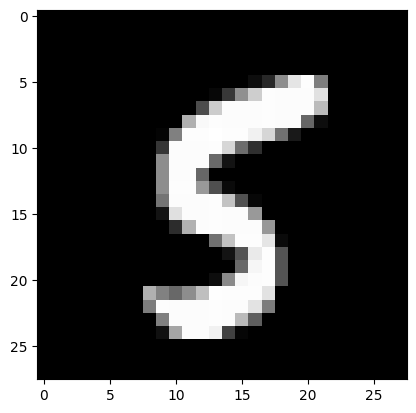

In [26]:
# first, let‘s generate a random number with numpy random, so everytime we get a different image
random_nr = np.random.randint(0, 60000)

# now, let‘s use imshow() to visualize the random number from our train dataset
plt.imshow(X_train[random_nr], cmap="gray");

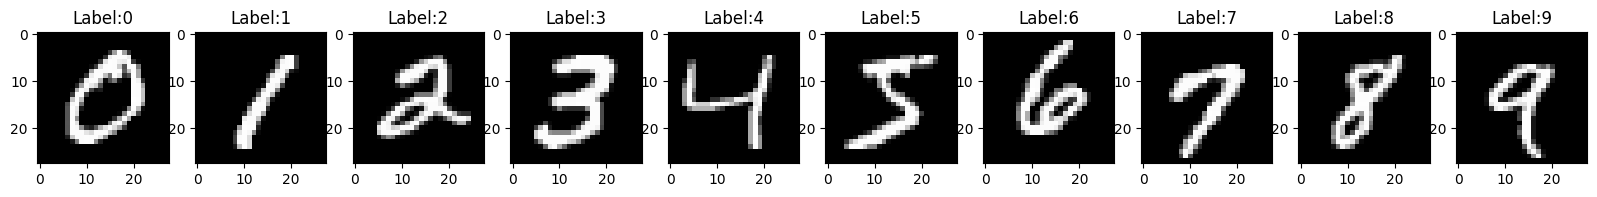

In [27]:
# Let‘s visualize one example per each digit using a for loop and matplotlib subplot
num_classes = 10

# Create a subplot
fig, ax = plt.subplots(1, num_classes, figsize=(20,20)) # 1 row, 10 columns (num_classes)

# Loop through 10 classes from train dataset and add labels from test dataset
for i in range(num_classes):
  sample = X_train[y_train == i][0]
  ax[i].imshow(sample, cmap="gray")
  ax[i].set_title(f"Label:{i}")

## Classes to categories
Next step is to convert our 10 classes to binary categories. For example, if a model classifies a digit on an image as a number `3`, it will correspond with `1`, while other categories will be `0`, Like this:

[0]  [0]  [0]  [1]  [0]  [0]  [0]  [0]  [0] [0]

To convert classes to categories, we will use a numpy utility library from `keras` and its `to_categorical()` method. `to_categorical()` accepts 2 parameters. First parameter is the vector which has integers that represent the various classes in the data.The second parameter is the number of classes.  

In [28]:
# encode labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [29]:
for i in range(10):
  print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# Data pre-processing 
The next step is data preprocessing. For the machine learning algorithm to understand our data better, we need to do two things: normalize the data, and flatten it into a vector.

## Feature scaling
Feature scaling helps us make diffent variables of the dataset more uniform, and improve the performance of machine learning algorithm. This is important, because if the values of a certain feature are higher, the algorithm is very likely to interpret them as more important, than features with smaller values. For example, if we have a variable "age" with a range of values (15, 26, 34, 56, 61) and a variable "height" with a range of values (165, 172, 184, 201), the machine learning algorithm might develop bias, and treat "height" as more important than "age", because the numbers are higher. In order to void that, we need to peroform feature scaling. 

There are several methods to approach feature scaling:

1. Standardization

In standardization, we center all values around 0.

2. Normalization

In data normalization, all values are rescaled so they fir between 0 and 1. It is also known as Min-Max scaling. For image processing, it is more common to use normalization, so this is the approach we are going to take today as well.

In image processing, normalization changes the range of pixel intensity values, and fits them in a range between 0 and 1 by dividing the image by 255 (the maximum pixel value).

## Reshape data to a vector (flatten)

The primary reason behind why we flatten images (multi-dimensional arrays) into 1-D array is because they take less memory, and as a result reduce the amount of time needed to train the model. There are two `numpy` methods we can choose from:
1. `numpy.flatten()`

This method flattens the array regardless of its shape, and has no required parameters.

2. `numpy.reshape()`

The reshape method converts an array from one shape to another shape, and takes two parameters: the array we want to reshape, and it‘s new shape as a tuple (num1, num2).


In [30]:
# normalize the images
X_train = X_train/255.0
X_test = X_test/255.0

In [31]:
# reshape data
X_train.shape

(60000, 28, 28)

In [32]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [33]:
X_train.shape

(60000, 784)

# Fully Connected Neural Network
Now it‘s time to build our first neural network! For this project, we will build a simple **fully connected neural network** which consists of a serious of layers in which every neuron in one layer is connected to every neuron in the other layer. The main advantage of fully connected neural networks is that they can be used for a broad range of pattern recognition tasks. Compared to more "specialized" artificial networks, such as CNN or RNN, however, they tend to perform worse for specific problems. 

## Model
When we are building a model in Keras, we have two optins: to build a **Sequential** model, of a **Functional**  model. **Sequential** models are the most common type, and we can use it to create the models by stacking layers in a particular sequence that we choose. **Functional** models, on the other hand, are used to create models with extra flexibility, such as connecting layers to more then one previous and one next layer. In other words, it allows us to create more complex and sophisticated networks. 

For this project, we will create a **Sequential** model.

## Layers
There are 3 types of layers in a neural network: an ** input layer**, a **hidden layer(s)**, and an **output layer**.  In our case, we will create a simple neural network with 1 input layer, 1 output layer, and 2 hidden layers: a dense and a dropout layer.

### Dense layer
Dense layer is the type of a layer in which all neurons are connected with all neurons of the previous layer.  As the first parameter, `Dense()` layer accepts the number of neurons we want the layer to have.

### Dropout Layer
Dropout layer is used as a method of regularization. Dropout layer randomly drops nodes (neurons), and forces the neurons in previous layers to take more or less responsibilites, and thus eliminates overfitting.

## Activation functions

Each layer in a neural network has an activation function. It tells each neuron how to transform the data it has, before sending it to the next layer. The most common activation function for hidden layers is ReLU, sigmoid, and tanh.

The most common activation functions for the **output layer** are linear, logistic (sigmoid), and softmax. The choice of the output function depends on the type of the problem we are trying to solve. For regression problems, linear activation function is common. For classification problems, we can use a sigmoid for binary or multilabel, and softmax for multiclass classification.

For our problem today, we will use **ReLU as our hidden layer activation** function, because we are dealing with images, and a **softmax activation for an output layer** , because it is a multiclass classification problem. 

## Loss and Optimizer functions

Apart from the activation functions, we also need to decide on loss and optimizer functions, when building a neural network. 

### Loss
Loss function calculates how wrong the prediction is. For classification problems, there are several options of loss functions:

* Binary Classification:
  * Binary Cross-Entropy
  > default loss function for binary classification
  * Hinge Loss
  > primary developed for Support Vector Machines (SVM)

* Multi-Class Classification:
 * Multi-Class Cross-Entropy Loss
 > default loss function for multiclass classification (can belong to more than one class)
 * Categorical cross-entropy
 > each output can belong to only one class
 * Sparse Multiclass Cross-Entropy Loss
 > no need for one-hot encoding, good for problems with large number of labels

For our project, we will use the **categorical cross-entropy** function, because each image can only signify one number. 

### Optimizer 
Optimizer helps us correctly modify the weights of the neurons and the learning rate to reduce the loss and improve accuracy. Optimizers can be broadly divided into two categories: **Gradient descent** and **Adaptive** optimizers. The principal difference between the two groups is that for gradient descent optmizers, we need to tune the learning rate manually, while adaptive optimizers do it automatically.

For this project, we will use an adaptive **Adam**  optimzier, which is currently considered to be the best optimizer overall.

In [34]:
#instanitiating the model
model = Sequential()

model.add(Dense(units=128, input_shape=(784, ), activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(units=10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/home/gk/miniconda3/envs/zkml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

That‘s it! All of that text for just one cell!

Now that we compiled our model, the next step is to actually fit it to our data. But before we do that, let‘s  talk about batch size and epochs.

## Batch size
Batch size refers to the number of samples used in one iteration.
Typically, we have 3 options to choose from.
* Batch mode
Using all the data in the dataset. Has long iteration times. 
* Mini-batch mode
Using parts of the dataset. Faster learning than in the batch mode. Typical mini-batch sizes are 32, 64, 128, 256, and 512. The advised mini-batch size is 32. 
* Stochastic mode
Using one sample per iteration.

We are going to use a **mini-batch mode**, and because our problem is very simple, and we will use **512 batch size**.

## Epochs
When all data we have  has updated the internal parameters, that equals to one epoch. There are many strategies to chose the best number of epochs. Some people swear by 11 epochs. Other people give other numbers. But the best way to decide if you have too many or too little epochs is to look at the model perofrmance. If the model keeps improving, it is advisable to try a higher numebr of epochs. If the model stopped improving way before the final epoch, it is advisable to try a lower number of epochs. 

In [35]:
# training the model 
BATCH_SIZE = 512
epochs = 10
model.fit(x=X_train, y=y_train, batch_size = BATCH_SIZE, epochs = epochs )

Epoch 1/10


2024-06-17 14:30:40.286427: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6869 - loss: 1.0310
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9299 - loss: 0.2408
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9504 - loss: 0.1667
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9613 - loss: 0.1311
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9676 - loss: 0.1068
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9731 - loss: 0.0874
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9760 - loss: 0.0776
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9807 - loss: 0.0651
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9812 - loss: 0.0603
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9843 - loss: 0.0522


## Model evaluation

Now that we have compiled and fitted our model, it is time to evaluate its performance. Since it is a classification problem, we can use the typical classification evaluation tools, such as accuracy, and loss.
Similarly to machine learning problems, we evaluate the model on test data - the data that our algorithm hasn‘t seen yet. If we want to compare test data evaluation with train data performance, we can also see both.

In [36]:
# Evaluate train and test 
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print results
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

2024-06-17 14:30:58.734208: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9909 - loss: 0.0337
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0847
Train Loss: 0.03328147530555725, Train Accuracy: 0.9908333420753479
Test Loss: 0.07498714327812195, Test Accuracy: 0.9771000146865845


We can see that the test loss is higher than the train loss, and train accuracy is higher than test accuracy. It is good, and means that our model is performing well, and doesn‘t overfit.

## Make predictions
Now that we trained and evaluated out model, let‘s try making predictions! **Softmax activation** function that we used for our **output layer** returns the predictions as a vector of probabilities. For example, "this image is 86% likely to be number 7, and this image has a 14% probability of being number 2."


In [37]:
# Predict labels on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) # pick the highest probability with "np.argmax()", and turn it into an index uing "axis=1"

# print vector of probabilities
print(f"What Softmax predicted: {y_pred}")

# print predicted number
print(f"What Softmax actually means: {y_pred_classes}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
What Softmax predicted: [[4.4322590e-07 6.2633222e-07 4.8004935e-05 ... 9.9965239e-01
  6.1085170e-06 2.0999281e-05]
 [3.0427387e-08 1.0147421e-04 9.9984694e-01 ... 2.4498991e-08
  1.5449561e-05 1.4839803e-10]
 [3.1847030e-05 9.9751693e-01 3.5828850e-04 ... 1.0617768e-03
  6.0966919e-04 3.2616037e-05]
 ...
 [1.0416867e-09 6.0385594e-09 5.5938243e-10 ... 2.6852008e-06
  1.1058738e-05 3.3516633e-05]
 [3.0899447e-08 7.9096427e-09 1.2726193e-09 ... 1.5278781e-08
  3.6391561e-05 1.7992644e-08]
 [1.0514881e-07 1.7549134e-10 6.9729360e-08 ... 3.2170898e-11
  1.0919439e-09 3.6688588e-10]]
What Softmax actually means: [7 2 1 ... 4 5 6]


Let‘s view a single random example. Because we use `random`, each time we refresh the cell, we will get a new sample.

In [38]:
# choose a random sample from all the test data
random_num = np.random.choice(len(X_test))
X_sample = X_test[random_num]

# save true label of this sample in a variable
y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_num]

# save a predicted label of this sample in a variable
y_sample_pred_class = y_pred_classes[random_num]

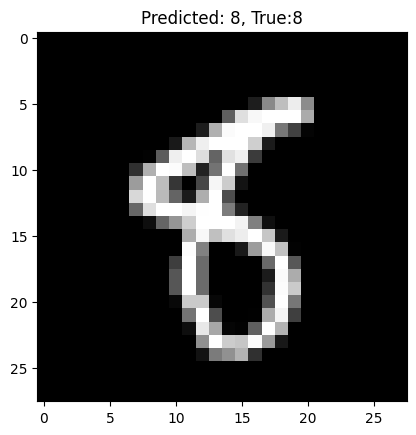

In [39]:
# visualize
%matplotlib inline
plt.title(f"Predicted: {y_sample_pred_class}, True:{y_sample_true}")
plt.imshow(X_sample.reshape(28, 28), cmap="gray")
plt.show()
# plt.figure()

## Confusion matrix
Another effective way to see the accuracy of a classification model is by making a confusion matrix.

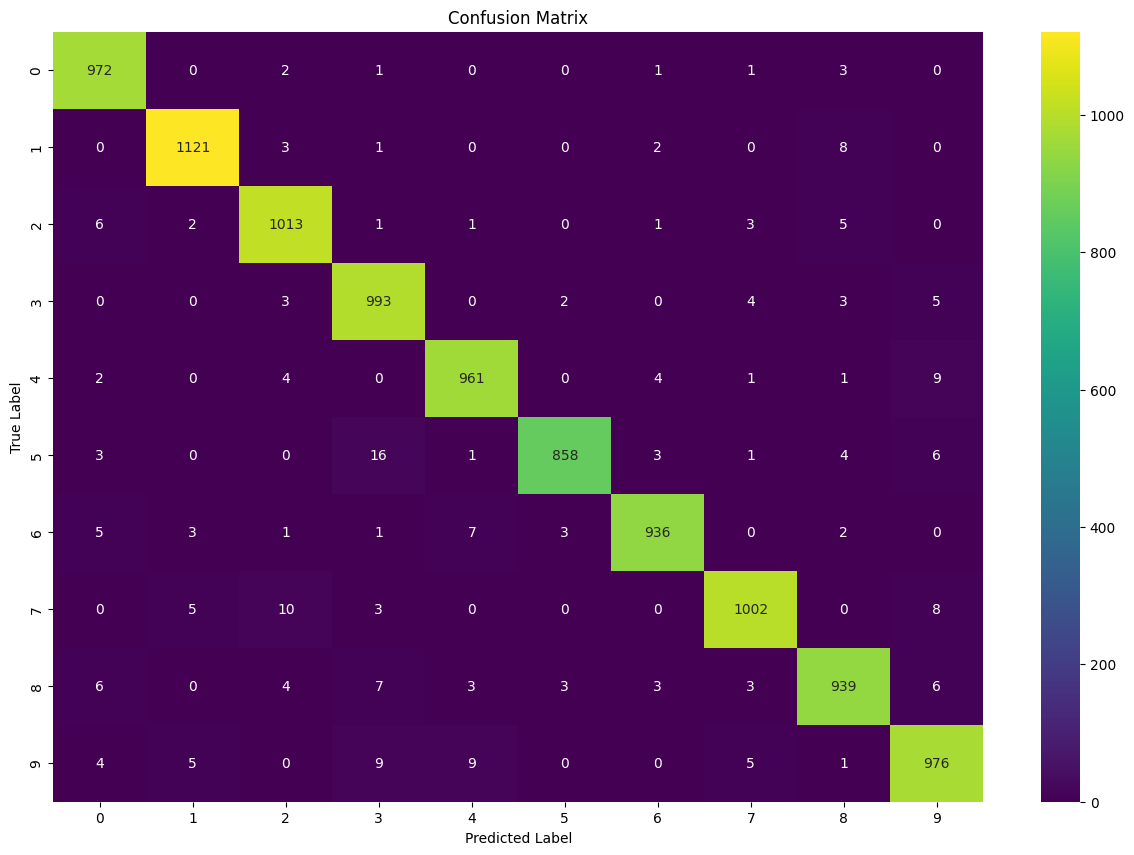

In [40]:
# generate a confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# visualize confusion matrix with matplotlib and seaborn
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="viridis")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")
plt.show()

## Conclusion
As we can see, our model performed pretty well, and the absolute majority of the labels were correct. In this notebook, we learned how to create a simple neural network, about the types of the layers, activation and loss functions, and optimizers. We also learned how to pre-process images through normalization, and how to evaluate our model after fitting it with accuracy and confusion matrix.

In [42]:
np.mean(y_true == y_pred_classes)

0.9771

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy, Precision, Recall, F1 Score for Torch model
accuracy = accuracy_score(y_true , y_pred_classes)
precision = precision_score(y_true , y_pred_classes, average='macro')
recall = recall_score(y_true , y_pred_classes, average='macro')
f1 = f1_score(y_true , y_pred_classes, average='macro')

# Print the metrics
print("Torch Model - Accuracy:", accuracy, "Precision:", precision, "Recall:", recall, "F1 Score:", f1)

Torch Model - Accuracy: 0.9771 Precision: 0.9772371052473492 Recall: 0.9767861597478076 F1 Score: 0.9769644827881347
